<a href="https://colab.research.google.com/github/yuyeonee/NLP_with_Disaster_Tweets/blob/main/pre_spacy_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 내가 원래 했던 거 nltk

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
import gc
import operator


from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Bidirectional,BatchNormalization
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

In [ ]:
for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna('Unknown')
train.head()

,id,keyword,location,text,target
0,1,Unknown,Unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,Unknown,Unknown,Forest fire near La Ronge Sask. Canada,1
2,5,Unknown,Unknown,All residents asked to 'shelter in place' are ...,1
3,6,Unknown,Unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,Unknown,Unknown,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
!pip install emot

In [ ]:
from emot.emo_unicode import UNICODE_EMOJI

# Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

train['text'] = train['text'].apply(lambda x: convert_emojis(x))
test['text'] = test['text'].apply(lambda x: convert_emojis(x))

In [ ]:
from string import ascii_lowercase

alphabet_list = list(ascii_lowercase)

stop_list = list(stop)
for alph in alphabet_list:
    stop_list.append(alph)


In [ ]:
stop_list.sort(reverse=True)
stop_list

['z',
 'yourselves',
 'yourself',
 'yours',
 'your',
 "you've",
 "you're",
 "you'll",
 "you'd",
 'you',
 'y',
 'y',
 'x',
 "wouldn't",
 'wouldn',
 "won't",
 'won',
 'with',
 'will',
 'why',
 'whom',
 'who',
 'while',
 'which',
 'where',
 'when',
 'what',
 "weren't",
 'weren',
 'were',
 'we',
 "wasn't",
 'wasn',
 'was',
 'w',
 'very',
 've',
 'v',
 'up',
 'until',
 'under',
 'u',
 'too',
 'to',
 'through',
 'those',
 'this',
 'they',
 'these',
 'there',
 'then',
 'themselves',
 'them',
 'theirs',
 'their',
 'the',
 "that'll",
 'that',
 'than',
 't',
 't',
 'such',
 'some',
 'so',
 "shouldn't",
 'shouldn',
 "should've",
 'should',
 "she's",
 'she',
 "shan't",
 'shan',
 'same',
 's',
 's',
 're',
 'r',
 'q',
 'p',
 'own',
 'over',
 'out',
 'ourselves',
 'ours',
 'our',
 'other',
 'or',
 'only',
 'once',
 'on',
 'off',
 'of',
 'o',
 'o',
 'now',
 'not',
 'nor',
 'no',
 "needn't",
 'needn',
 'n',
 'myself',
 'my',
 "mustn't",
 'mustn',
 'most',
 'more',
 "mightn't",
 'mightn',
 'me',
 'ma',

In [ ]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


In [ ]:
train = train.drop_duplicates(['keyword', 'location', 'text'])
test = test.drop_duplicates(['keyword', 'location', 'text'])

In [ ]:
print(train.shape)
print(test.shape)

(7552, 5)
(3252, 4)


In [ ]:
# Function for cleaning signs
def clean(tweet):

    '''# remove @tweet_id
    tweet = re.sub(r'@\S+', '', tweet)'''

    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

    # lowercase
    tweet = tweet.lower()

    # stopword
    tweet = word_tokenize(tweet)
    tweet = [word for word in tweet if word not in stop]
    tweet = [word for word in tweet if not word.isdigit()]

    tweet = ' '.join(tweet)

    # remove non-ascii
    tweet = re.sub(r'[^\x00-\x7f]',r' ', tweet)

    # Remove punctuation
    tweet = re.sub(r'[^\w\s]','', tweet)

    return tweet

train['text_cleaned'] = train['text'].apply(lambda s : clean(s))
test['text_cleaned'] = test['text'].apply(lambda s : clean(s))

<ipython-input-179-296682f0dcb4>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text_cleaned'] = train['text'].apply(lambda s : clean(s))
<ipython-input-179-296682f0dcb4>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['text_cleaned'] = test['text'].apply(lambda s : clean(s))


In [ ]:
train.head(20)

,id,keyword,location,text,target,text_cleaned
0,1,Unknown,Unknown,deeds reason earthquake may allah forgive us,1,deeds reason earthquake may allah forgive us
1,4,Unknown,Unknown,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada
2,5,Unknown,Unknown,residents asked shelter place notified officer...,1,residents asked shelter place notified officer...
3,6,Unknown,Unknown,13000 people receive wildfires evacuation orde...,1,people receive wildfires evacuation orders cal...
4,7,Unknown,Unknown,got sent photo ruby alaska smoke wildfires pou...,1,got sent photo ruby alaska smoke wildfires pou...
5,8,Unknown,Unknown,rockyfire update california hwy closed directi...,1,rockyfire update california hwy closed directi...
6,10,Unknown,Unknown,flood disaster heavy rain causes flash floodin...,1,flood disaster heavy rain causes flash floodin...
7,13,Unknown,Unknown,m top hill see fire woods,1,top hill see fire woods
8,14,Unknown,Unknown,s emergency evacuation happening building acro...,1,emergency evacuation happening building across...
9,15,Unknown,Unknown,m afraid tornado coming area,1,afraid tornado coming area


In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
# Function for converting abbreviations into word
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

train["text"] = train["text_cleaned"].apply(lambda x: convert_abbrev_in_text(x))
test["text"] = test["text_cleaned"].apply(lambda x: convert_abbrev_in_text(x))

<ipython-input-184-74ee52419d96>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["text"] = test["text_cleaned"].apply(lambda x: convert_abbrev_in_text(x))


In [ ]:
train.head(50)

,id,keyword,location,text,target,text_cleaned
0,1,Unknown,Unknown,deeds reason earthquake may allah forgive us,1,deeds reason earthquake may allah forgive us
1,4,Unknown,Unknown,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada
2,5,Unknown,Unknown,residents asked shelter place notified officer...,1,residents asked shelter place notified officer...
3,6,Unknown,Unknown,people receive wildfires evacuation orders cal...,1,people receive wildfires evacuation orders cal...
4,7,Unknown,Unknown,got sent photo ruby alaska smoke wildfires pou...,1,got sent photo ruby alaska smoke wildfires pou...
5,8,Unknown,Unknown,rockyfire update california hwy closed directi...,1,rockyfire update california hwy closed directi...
6,10,Unknown,Unknown,flood disaster heavy rain causes flash floodin...,1,flood disaster heavy rain causes flash floodin...
7,13,Unknown,Unknown,top hill see fire woods,1,top hill see fire woods
8,14,Unknown,Unknown,emergency evacuation happening building across...,1,emergency evacuation happening building across...
9,15,Unknown,Unknown,afraid tornado coming area,1,afraid tornado coming area


In [ ]:
test.head(50)

,id,keyword,location,text,text_cleaned
0,0,Unknown,Unknown,happened terrible car crash,happened terrible car crash
1,2,Unknown,Unknown,heard earthquake different cities stay safe ev...,heard earthquake different cities stay safe ev...
2,3,Unknown,Unknown,forest fire spot pond geese fleeing across str...,forest fire spot pond geese fleeing across str...
3,9,Unknown,Unknown,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfires
4,11,Unknown,Unknown,typhoon soudelor kills china taiwan,typhoon soudelor kills china taiwan
5,12,Unknown,Unknown,shaking earthquake,shaking earthquake
6,21,Unknown,Unknown,probably still show life arsenal yesterday eh eh,probably still show life arsenal yesterday eh eh
7,22,Unknown,Unknown,hey,hey
8,27,Unknown,Unknown,nice hat,nice hat
9,29,Unknown,Unknown,fuck,fuck


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from transformers import AutoTokenizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# 2. 토크나이징

# BERT 기반의 토크나이저
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if token.isalnum()]  # 알파벳과 숫자만 남기기
    return tokens

train['tokens'] = train['text'].apply(tokenize_text)
test['tokens'] = test['text'].apply(tokenize_text)
train['tokens'].head()
test['tokens'].head()

<ipython-input-202-32039c090081>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['tokens'] = test['text'].apply(tokenize_text)


0                     [happened, terrible, car, crash]
1    [heard, earthquake, different, cities, stay, s...
2    [forest, fire, spot, pond, geese, fleeing, acr...
3                [apocalypse, lighting, spokane, wild]
4                  [typhoon, so, kills, china, taiwan]
Name: tokens, dtype: object

In [ ]:
train.head(10)

,id,keyword,location,text,target,text_cleaned,tokens
0,1,Unknown,Unknown,deeds reason earthquake may allah forgive us,1,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,Unknown,Unknown,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, sas, canada]"
2,5,Unknown,Unknown,residents asked shelter place notified officer...,1,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o..."
3,6,Unknown,Unknown,people receive wildfires evacuation orders cal...,1,people receive wildfires evacuation orders cal...,"[people, receive, wild, evacuation, orders, ca..."
4,7,Unknown,Unknown,got sent photo ruby alaska smoke wildfires pou...,1,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wild, ..."
5,8,Unknown,Unknown,rockyfire update california hwy closed directi...,1,rockyfire update california hwy closed directi...,"[rocky, update, california, h, closed, directi..."
6,10,Unknown,Unknown,flood disaster heavy rain causes flash floodin...,1,flood disaster heavy rain causes flash floodin...,"[flood, disaster, heavy, rain, causes, flash, ..."
7,13,Unknown,Unknown,top hill see fire woods,1,top hill see fire woods,"[top, hill, see, fire, woods]"
8,14,Unknown,Unknown,emergency evacuation happening building across...,1,emergency evacuation happening building across...,"[emergency, evacuation, happening, building, a..."
9,15,Unknown,Unknown,afraid tornado coming area,1,afraid tornado coming area,"[afraid, tornado, coming, area]"


In [ ]:
#5. 표제어 추출 (어간 추출보다 성능 좋은듯..?)
nlp = spacy.load("en_core_web_sm")

def get_lemmas(tokens):
    text = " ".join(tokens)  # 토큰화된 리스트를 다시 문장으로 복원
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    lemmas = ' '.join(lemmas)
    return lemmas

# 'tokens' 열에 있는 토큰들을 이용하여 표제어 추출
train['lemmas'] = train['tokens'].apply(lambda x: get_lemmas(x))

# 결과 확인
print(train['lemmas'].head())

0          deed reason earthquake may allah forgive we
1                   forest fire near la ron sas canada
2    resident ask shelter place notify officer evac...
3      people receive wild evacuation order california
4    got send photo ruby alaska smoke wild pour school
Name: lemmas, dtype: object


In [ ]:
train.head()

,id,keyword,location,text,target,text_cleaned,tokens,lemmas
0,1,Unknown,Unknown,deeds reason earthquake may allah forgive us,1,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv...",deed reason earthquake may allah forgive we
1,4,Unknown,Unknown,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, sas, canada]",forest fire near la ron sas canada
2,5,Unknown,Unknown,residents asked shelter place notified officer...,1,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o...",resident ask shelter place notify officer evac...
3,6,Unknown,Unknown,people receive wildfires evacuation orders cal...,1,people receive wildfires evacuation orders cal...,"[people, receive, wild, evacuation, orders, ca...",people receive wild evacuation order california
4,7,Unknown,Unknown,got sent photo ruby alaska smoke wildfires pou...,1,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wild, ...",got send photo ruby alaska smoke wild pour school


In [ ]:
test['lemmas'] = test['tokens'].apply(lambda x: get_lemmas(x))
test.head()

<ipython-input-211-7be0590b2d49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lemmas'] = test['tokens'].apply(lambda x: get_lemmas(x))


,id,keyword,location,text,text_cleaned,tokens,lemmas
0,0,Unknown,Unknown,happened terrible car crash,happened terrible car crash,"[happened, terrible, car, crash]",happen terrible car crash
1,2,Unknown,Unknown,heard earthquake different cities stay safe ev...,heard earthquake different cities stay safe ev...,"[heard, earthquake, different, cities, stay, s...",hear earthquake different city stay safe everyone
2,3,Unknown,Unknown,forest fire spot pond geese fleeing across str...,forest fire spot pond geese fleeing across str...,"[forest, fire, spot, pond, geese, fleeing, acr...",forest fire spot pond geese flee across street...
3,9,Unknown,Unknown,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfires,"[apocalypse, lighting, spokane, wild]",apocalypse light spokane wild
4,11,Unknown,Unknown,typhoon soudelor kills china taiwan,typhoon soudelor kills china taiwan,"[typhoon, so, kills, china, taiwan]",typhoon so kill china taiwan


# 학습!!

In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.13.0
KerasNLP version: 0.6.1


In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = train["lemmas"]
y = train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test["lemmas"]

In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_6 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone_6        │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_6 (GetItem)          │ (None, 768)               │           0 │ distil_bert_backbone_6[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item_6[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
189/189 ━━━━━━━━━━━━━━━━━━━━ 152s 578ms/step - accuracy: 0.6868 - loss: 0.5900 - val_accuracy: 0.8081 - val_loss: 0.4398
Epoch 2/2
189/189 ━━━━━━━━━━━━━━━━━━━━ 85s 448ms/step - accuracy: 0.8165 - loss: 0.4253 - val_accuracy: 0.8213 - val_loss: 0.4162


In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step


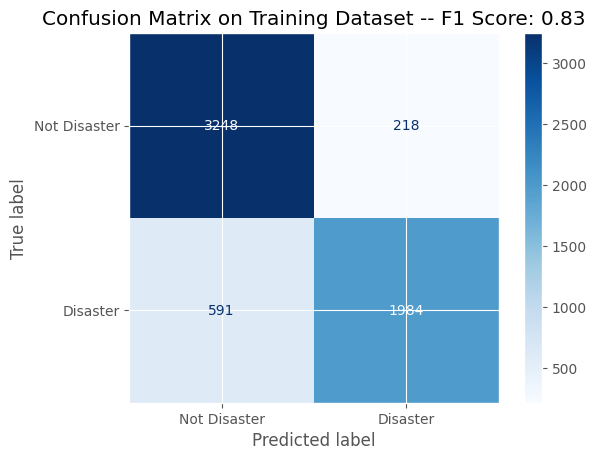

In [ ]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step


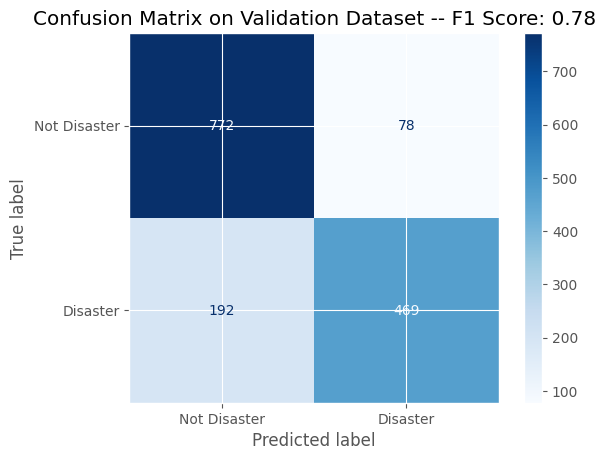

In [ ]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

## Spacy로 전처리 !

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from transformers import AutoTokenizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# 데이터 다시 불러오기
train_data = pd.read_csv('/content/drive/My Drive/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/test.csv')

In [ ]:
# 1. 소문자 통일 - 누락된 값 있다면 pd.isna() 활용해서 건너뛰기
train_data['keyword'] = train_data['keyword'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train_data['location'] = train_data['location'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train_data['text'] = train_data['text'].apply(lambda x: str.lower(x))

In [ ]:
# 1. 소문자 통일 - 누락된 값 있다면 pd.isna() 활용해서 건너뛰기
test_data['keyword'] = test_data['keyword'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
test_data['location'] = test_data['location'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
test_data['text'] = test_data['text'].apply(lambda x: str.lower(x))

In [ ]:
# 2. 토크나이징

# BERT 기반의 토크나이저
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if token.isalnum()]  # 알파벳과 숫자만 남기기
    return tokens

train_data['tokens'] = train_data['text'].apply(tokenize_text)

train_data['tokens'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ron, sas, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [13, 000, people, receive, wild, evacuation, o...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: tokens, dtype: object

In [ ]:
test_data['tokens'] = test_data['text'].apply(tokenize_text)

test_data['tokens'].head()

0            [just, happened, a, terrible, car, crash]
1    [heard, about, earthquake, is, different, citi...
2    [there, is, a, forest, fire, at, spot, pond, g...
3                [apocalypse, lighting, spokane, wild]
4     [typhoon, so, kills, 28, in, china, and, taiwan]
Name: tokens, dtype: object

In [ ]:
# 3. 불용어 처리
nlp = spacy.load("en_core_web_sm")
print(nlp.Defaults.stop_words)

def remove_stopwords(tokens):
    doc = nlp(" ".join(tokens))
    tokens_without_stopwords = [token.text for token in doc if not token.is_stop]
    return tokens_without_stopwords

train_data['tokens'] = train_data['tokens'].apply(remove_stopwords)

train_data['tokens'].head()


{'first', 'his', 'can', 'ours', 'bottom', 'became', "n't", 'more', 'regarding', 'those', 'until', 'seems', 'eleven', 'themselves', 'over', 'thru', 'amount', 'and', 'only', 'latter', 'call', 'very', 'anyway', 'almost', 'well', 'us', 'done', 'every', 'never', 'with', 'now', 'own', 'least', 'really', 'twenty', 'empty', 'under', 'latterly', 'anyone', 'show', 'become', 'whoever', 'something', 'into', 'who', 'ten', 'whatever', 'each', 'get', 'a', 'nowhere', 'somehow', '’ve', 'but', 'thereby', 'everyone', 'various', 'cannot', 'itself', 'after', 'between', 'while', 'someone', 'where', 'full', '’re', 'please', 'nobody', 'whole', 'ca', 'anywhere', "'ll", 'not', 'thence', 'again', 'via', 'she', 'an', 'therein', 'them', 'there', '‘ve', "'re", 'these', 'front', 'yours', '‘ll', 'together', 'any', 'even', 'you', 'move', 'might', 'above', 'fifty', 'as', 'besides', 'yet', 'always', 'been', 'n‘t', 'hereafter', 'put', 'elsewhere', 'at', 'this', 'against', "'m", 'meanwhile', 'take', 'somewhere', 'both', '

0          [deeds, reason, earthquake, allah, forgive]
1           [forest, fire, near, la, ron, sas, canada]
2    [residents, asked, shelter, place, notified, o...
3    [13, 000, people, receive, wild, evacuation, o...
4    [got, sent, photo, ruby, alaska, smoke, wild, ...
Name: tokens, dtype: object

In [ ]:
test_data['tokens'] = test_data['tokens'].apply(remove_stopwords)

test_data['tokens'].head()

0                     [happened, terrible, car, crash]
1    [heard, earthquake, different, cities, stay, s...
2    [forest, fire, spot, pond, geese, fleeing, str...
3                [apocalypse, lighting, spokane, wild]
4                  [typhoon, kills, 28, china, taiwan]
Name: tokens, dtype: object

In [ ]:
# 4. location 나라 -> 수도 일단 안 함

# 이건 왜 문제일까???
country_count = {}
for location in train_data['location']:
    if not pd.isna(location):
        if location not in country_count:
            country_count[location] = 1
        else:
            country_count[location] += 1

print(country_count)


country_to_capital = {
    'korea': 'seoul',
    'US': 'washington D.C.',
    'U.S.': 'washington D.C.',
    'United States': 'washington D.C.',
    'United States of America': 'washington D.C.',
    'japan': 'tokyo',
    'china': 'beijing',
}

# 'location' 열의 값을 변경하여 수도로 바꾸기
train_data['location'] = train_data['location'].map(country_to_capital)

In [ ]:
#5. 표제어 추출 (어간 추출보다 성능 좋은듯..?)
nlp = spacy.load("en_core_web_sm")

def get_lemmas(tokens):
    text = " ".join(tokens)  # 토큰화된 리스트를 다시 문장으로 복원
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    lemmas = [word for word in lemmas if not word.isdigit()]

    lemmas = ' '.join(lemmas)
    return lemmas

# 'tokens' 열에 있는 토큰들을 이용하여 표제어 추출
train_data['lemmas'] = train_data['tokens'].apply(get_lemmas)

# 결과 확인
print(train_data['lemmas'].head())

0                 deed reason earthquake allah forgive
1                   forest fire near la ron sas canada
2    resident ask shelter place notify officer evac...
3      people receive wild evacuation order california
4    got send photo ruby alaska smoke wild pour school
Name: lemmas, dtype: object


In [ ]:
# 'tokens' 열에 있는 토큰들을 이용하여 표제어 추출
test_data['lemmas'] = test_data['tokens'].apply(get_lemmas)

# 결과 확인
test_data['lemmas'].head()

0                       happen terrible car crash
1        hear earthquake different city stay safe
2    forest fire spot pond geese flee street save
3                   apocalypse light spokane wild
4                       typhoon kill china taiwan
Name: lemmas, dtype: object

In [ ]:
train_data.head(20)

,id,keyword,location,text,target,tokens,lemmas
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,"[deeds, reason, earthquake, allah, forgive]",deed reason earthquake allah forgive
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,"[forest, fire, near, la, ron, sas, canada]",forest fire near la ron sas canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13, 000, people, receive, wild, evacuation, o...",people receive wild evacuation order california
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wild, ...",got send photo ruby alaska smoke wild pour school
5,8,NaN,NaN,#rockyfire update => california hwy. 20 closed...,1,"[rocky, update, california, h, 20, closed, dir...",rocky update california h closed direction lak...
6,10,NaN,NaN,#flood #disaster heavy rain causes flash flood...,1,"[flood, disaster, heavy, rain, causes, flash, ...",flood disaster heavy rain cause flash flooding...
7,13,NaN,NaN,i'm on top of the hill and i can see a fire in...,1,"[m, hill, fire, woods]",m hill fire wood
8,14,NaN,NaN,there's an emergency evacuation happening now ...,1,"[s, emergency, evacuation, happening, building...",s emergency evacuation happen build street
9,15,NaN,NaN,i'm afraid that the tornado is coming to our a...,1,"[m, afraid, tornado, coming, area]",m afraid tornado come area


In [ ]:
test_data.head(20)

,id,keyword,location,text,tokens,lemmas
0,0,NaN,NaN,just happened a terrible car crash,"[happened, terrible, car, crash]",happen terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, s...","[heard, earthquake, different, cities, stay, s...",hear earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, geese, fleeing, str...",forest fire spot pond geese flee street save
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,"[apocalypse, lighting, spokane, wild]",apocalypse light spokane wild
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,"[typhoon, kills, 28, china, taiwan]",typhoon kill china taiwan
5,12,NaN,NaN,we're shaking...it's an earthquake,"[shaking, s, earthquake]",shake s earthquake
6,21,NaN,NaN,they'd probably still show more life than arse...,"[d, probably, life, arsenal, yesterday, eh, eh]",d probably life arsenal yesterday eh eh
7,22,NaN,NaN,hey! how are you?,[hey],hey
8,27,NaN,NaN,what a nice hat?,"[nice, hat]",nice hat
9,29,NaN,NaN,fuck off!,[fuck],fuck


In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = train_data["lemmas"]
y = train_data["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test_data["lemmas"]

In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_2 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone_2        │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │           0 │ distil_bert_backbone_2[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 149s 564ms/step - accuracy: 0.7113 - loss: 0.5840 - val_accuracy: 0.8148 - val_loss: 0.4310
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 139s 727ms/step - accuracy: 0.8282 - loss: 0.4142 - val_accuracy: 0.8247 - val_loss: 0.4137


191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step


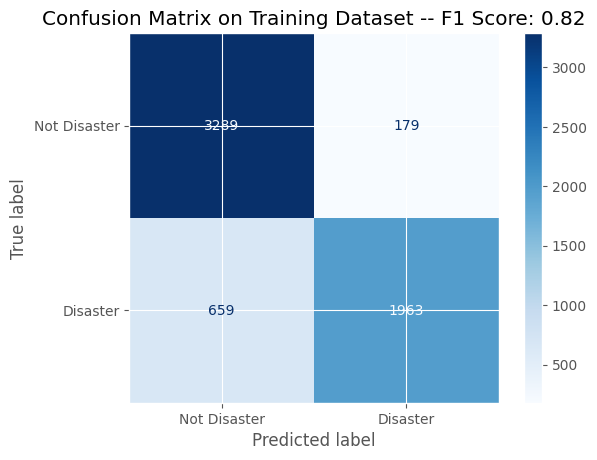

In [ ]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step


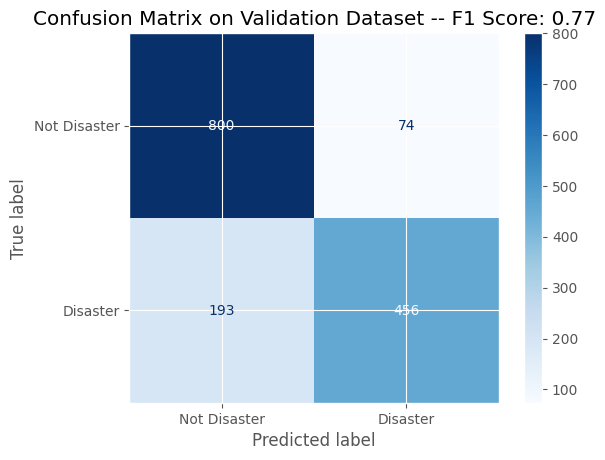

In [ ]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [ ]:
train_data.to_csv('train_FF.csv')

In [ ]:
test_data.to_csv('test_FF.csv')

In [ ]:
sample_submission = pd.read_csv("/content/drive/My Drive/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step


In [ ]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.353049
std,3146.427221,0.477991
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [ ]:
sample_submission.to_csv("submission_yu2.csv", index=False)

In [ ]:
train.head(10)

,id,keyword,location,text,target,text_cleaned
0,1,Unknown,Unknown,our deeds reason earthquake may allah forgive us,1,our deeds reason earthquake may allah forgive us
1,4,Unknown,Unknown,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada
2,5,Unknown,Unknown,all residents asked shelter place notified off...,1,all residents asked shelter place notified of...
3,6,Unknown,Unknown,13000 people receive wildfires evacuation orde...,1,13000 people receive wildfires evacuation ord...
4,7,Unknown,Unknown,just got sent photo ruby alaska smoke wildfire...,1,just got sent photo ruby alaska smoke wildfi...
5,8,Unknown,Unknown,rockyfire update california hwy closed directi...,1,rockyfire update california hwy closed dir...
6,10,Unknown,Unknown,flood disaster heavy rain causes flash floodin...,1,flood disaster heavy rain causes flash flood...
7,13,Unknown,Unknown,i m top hill i see fire woods,1,i m top hill i see fire woods
8,14,Unknown,Unknown,there s emergency evacuation happening buildin...,1,there s emergency evacuation happening buildin...
9,15,Unknown,Unknown,i m afraid tornado coming area,1,i m afraid tornado coming area
